
# Задача к лекции "Построение кривых доходности"


Построить кривую бенчмарка до 5 лет.  Цены свопов взять по ссылке ниже

https://www.chathamfinancial.com/technology/european-market-rates#view

Чтобы получить свой вариант - подставьте почту в функцию ниже


Текущее значение бечмарков по ссылкам ниже

* NIBOR  https://most.referanserenter.no/nibor-rates.html

* STIBOR https://swfbf.se/sfbf-benchmarks/rates/

* CIBOR  https://dfbf.dk/dfbf-benchmarks/rates/


In [1]:
def getBenchmark(email):
  import hashlib
  ccy = [ 'NIBOR', 'STIBOR', 'CIBOR']
  h = int(hashlib.sha1(email.encode('utf-8')).hexdigest(), 16)
  return ccy[h % 4]
getBenchmark('makxim.kiryakin@gmail.com')

'STIBOR'

Для честной цены однолетнего свопа использовать формулу


$$ \frac{Price}{4} (DF_{3m} + DF_{6m} + DF_{9m} + DF_{12m}) = \frac{1}{4}\left( Benchmark_{3M}(0)\cdot DF_{3m} + Benchmark_{3M}(3)\cdot DF_{6m} + Benchmark_{3M}(6)\cdot DF_{9m} + Benchmark_{3M}(9) \cdot DF_{12m}     \right) $$

$ Benchmark_{3M}(0) $ текущее значение 3М бенчмарка.

$ Benchmark_{3M}(3,6,9)$ неизвестны.

$ DF_{3m} = \frac{1}{1 + 0.25\cdot Benchmark_{3M}(0)}$

$ DF_{6m} = \frac{DF_{3m}}{1 + 0.25 \cdot Benchmark_{3M}(3)}$

$ DF_{9m} = \frac{DF_{6m}}{1 + 0.25\cdot Benchmark_{3M}(6)}$

$ DF_{12m} = \frac{DF_{9m}}{1 + 0.25 \cdot Benchmark_{3M}(9)}$


Построить используя интерпорялцию сплайнами


-----------------------------------------------------

**Формула честной цены свопа**

$$PV_{floating} = PV_{fixed}$$

$$PV_{floating} = \frac{1}{4}L_3D_{3M} + \frac{1}{4}L_{3, 6}D_{6M} + \frac{1}{4}L_{6, 9}D_{9M} + \frac{1}{4}L_{9, 12}D_{12M}  $$

$$PV_{floating} = \frac{S}{4}(D_{3M} + D_{6M} + D_{9M} + D_{12M} )$$


Покажем, что:

$$ {1\over 4}L_3D_3  + {1\over 4}L_{3,6}D_6 +  {1\over 4}L_{6,9}D_9 + {1\over 4}L_{9,12}D_{12} + D_{12} = 1$$

In [33]:
from sympy import symbols, simplify
x1, x2, x3, x4 = symbols('x1 x2 x3 x4')

d1 = 1 / (1 + 0.25*x1)
d2 = d1 / (1 + 0.25*x2)
d3 = d2 / (1 + 0.25*x3)
d4 = d3 / (1 + 0.25*x4)

In [34]:
simplify(0.25*x1*d1 + 0.25*x2*d2 + 0.25*x3*d3 + 0.25*x4*d4 + d4)

1.00000000000000

S - цена свопа, сколько сторона будет платить/получать на фиксированной ноге

$$PV_{floating} = 1 - D_{12}$$

$$S_{1Y} = \frac{4(1 - D_{12})}{D_3 + D_6 + D_9 + D_{12}}$$

------------------------

**Рыночные данные**

In [35]:
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
import collections
import seaborn as sns

In [36]:
L1 = -0.084         #STIBOR на 1 месяц
L3 = 0.065          #STIBOR на 3 месяца
L6 = 0.317          #STIBOR на 6 месяца
S1 = 0.689          #цена свопа на 1 года
S2 = 1.392 	        #цена свопа на 2 года
S3 = 1.658 	        #цена свопа на 3 года
S5 = 1.819 	        #цена свопа на 5 года

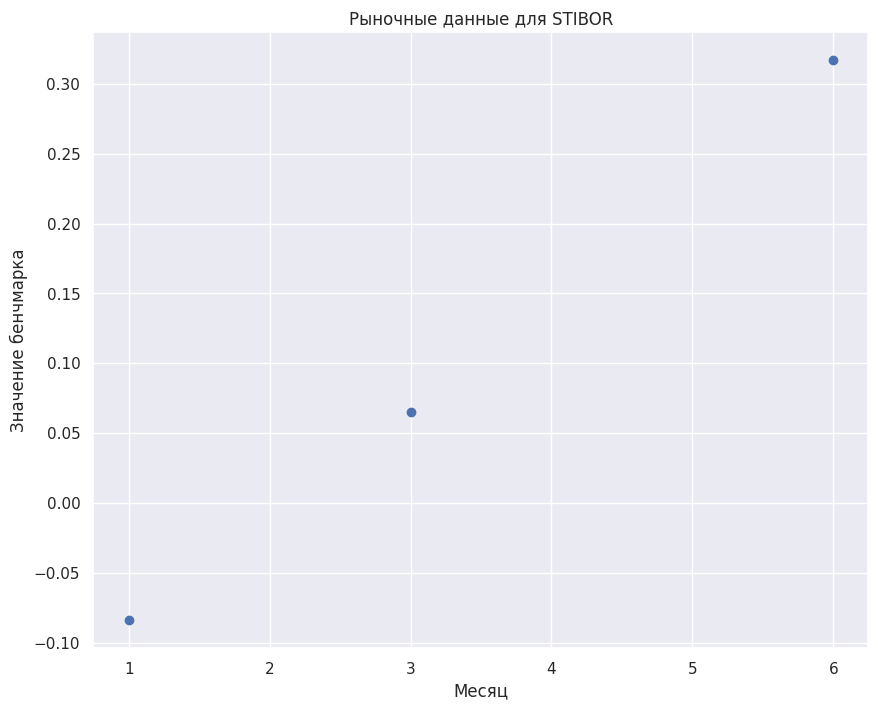

In [38]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 8))

plt.title("Рыночные данные для STIBOR")
plt.xlabel("Месяц")
plt.ylabel("Значение бенчмарка")

plt.scatter([1, 3, 6], [L1, L3, L6]);

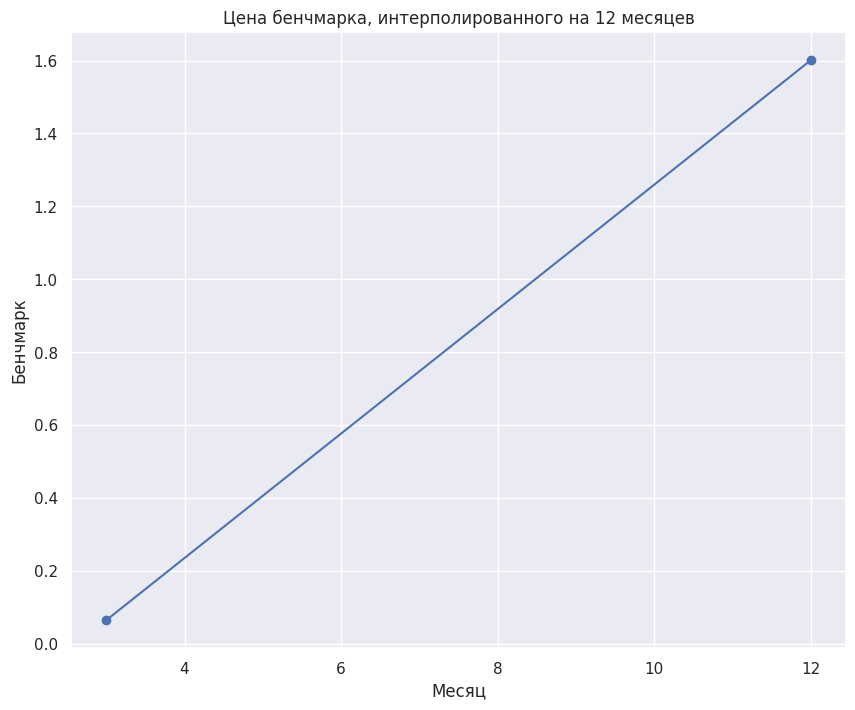

In [39]:
def F(x, S1, L3):
    f = scipy.interpolate.interp1d([3, 12], [L3,  x], 'linear')
    D3 = 1 / (1 + 0.25*L3)
    D6 = D3 / (1 + 0.25*f(6))
    D9 = D6 / (1 + 0.25*f(9))
    D12 = D9 / (1 + 0.25*x)

    return 0.25*S1*(D3 + D6 + D9 + D12) - 1 + D12

plt.figure(figsize=(10, 8))
L12 = scipy.optimize.broyden1(lambda x: F(x,S1,L3), 1.0, f_tol=1e-6)
f = scipy.interpolate.interp1d([3,12], [L3,L12], 'linear')
tenors =[3, 12]
plt.xlabel("Месяц")
plt.ylabel("Бенчмарк")
plt.title("Цена бенчмарка, интерполированного на 12 месяцев")
plt.scatter(tenors, f(tenors))
plt.plot(tenors, f(tenors));

Теперь я посчитаю значения для L3_6 и L9_12


$$ D_6 = \frac{1}{1 + 0.5L_6} = D_3 \cdot D_{3,6} =\frac{1}{1 + 0.25L_3} \cdot \frac{1}{1 + 0.25L_{3,6}}$$

In [40]:
from sympy import solve, N
l3, l6, x = symbols('L3 L6 x')
solve((1 + 0.5*l6) - (1 + 0.25*l3)*(1 + 0.25*x), x)

[4.0*(-L3 + 2.0*L6)/(L3 + 4.0)]

In [41]:
L3_6 = 4.0*(-L3 + 2.0*L6)/(L3 + 4.0)
print(L3_6)

0.55990159901599


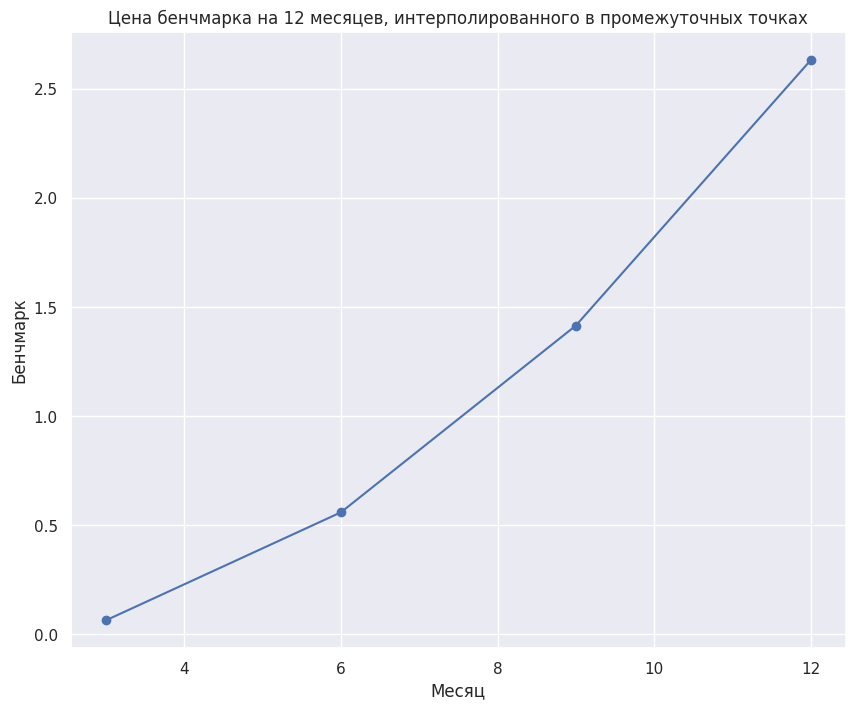

In [43]:
def implyD12(L3, L3_6, x):
    f = scipy.interpolate.interp1d([3,6,12], [L3,L3_6,x], 'quadratic')
    L6_9 = f(9)
    D3 = 1/(1 + 0.25*L3)
    D6 = D3/(1 + 0.25*L3_6)
    D9 = D6/(1 + 0.25*L6_9)
    D12 = D9/(1 + 0.25*x)
    return D12

D12 = 1 / (1 + L12)
L9_12 = scipy.optimize.broyden1(lambda x: implyD12(L3,L3_6,x) - D12,
                                1.0, f_tol=1e-6)
f = scipy.interpolate.interp1d([3,6,12], [L3,L3_6,L9_12], 'quadratic')
tenors1Y = [3,6,9,12]
curve1Y = f(tenors1Y)

plt.figure(figsize=(10, 8))
plt.xlabel("Месяц")
plt.ylabel("Бенчмарк")
plt.title("Цена бенчмарка на 12 месяцев, интерполированного в промежуточных точках")

plt.scatter(tenors1Y, curve1Y)
plt.plot(tenors1Y, curve1Y);

Теперь посчитаю L24 исходя из цены свопа на 2 года


$$S_{2Y} = \frac{1 - D_{24M}}{0.5 (D_{6M} + D_{12M} + D_{18M} + D_{24M}) }$$

In [44]:
L = np.array([L3, L3_6, L9_12])

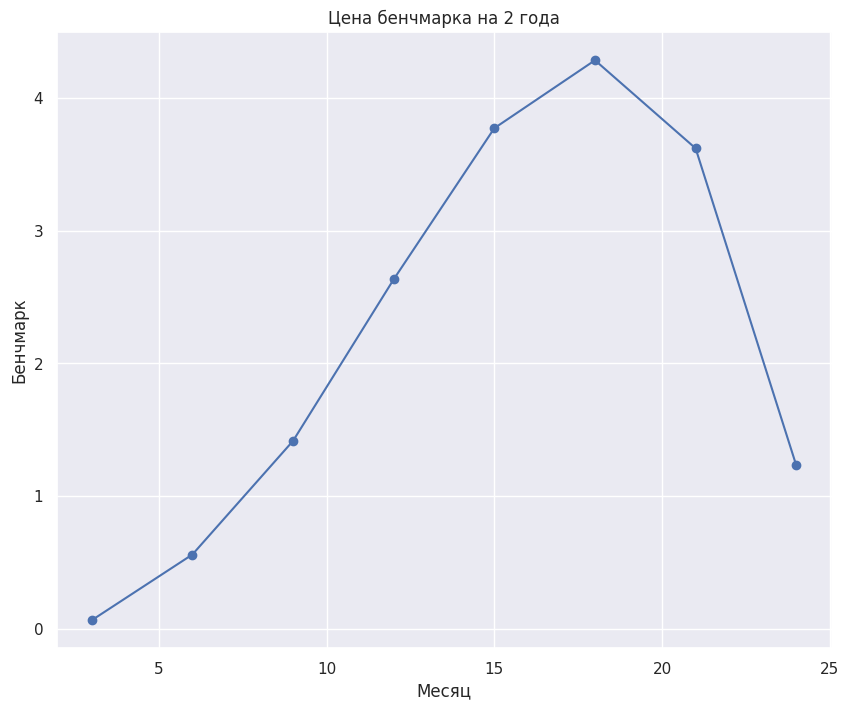

In [45]:
def F(x, S2, L):
    D3 = 1/(1 + 0.25*L[0])
    D6 = D3/(1 + 0.25*L[1])
    D9 = D6/(1 + 0.25*L[2])
    D12 = D9/(1 + 0.25*L[3])

    f = scipy.interpolate.interp1d([3,6,9,12,24],
                                   np.append(L,x), 'cubic')
    D15 = D12/(1 + 0.25*f(15))
    D18 = D15/(1 + 0.25*f(18))
    D21 = D18/(1 + 0.25*f(21))
    D24 = D21/(1 + 0.25*x)
    return 0.5*S2*(D6 + D12 + D18 + D24) - 1 + D24

L24 = scipy.optimize.broyden1(lambda x: F(x,S2,curve1Y), 1.0, f_tol=1e-6)
f = scipy.interpolate.interp1d([3,6,9,12,24], np.append(curve1Y, L24)
                               , 'cubic')

plt.figure(figsize=(10, 8))
plt.xlabel("Месяц")
plt.ylabel("Бенчмарк")
plt.title("Цена бенчмарка на 2 года")
tenors2Y = [3,6,9,12,15,18,21,24]

curve2Y = f(tenors2Y)
plt.scatter(tenors2Y, curve2Y)
plt.plot(tenors2Y, curve2Y);

# Теперь посчитаю L36 исходя из цены свопа на 3 года

In [26]:
tenors3Y = [3,6,9,12,15,18,21,24, 27, 30, 33, 36]


$$S_{3Y} = \frac{1 - D_{36M}}{0.5 (D_{6M} + D_{12M} + D_{18M} + D_{24M}+ D_{30M} + D_{36M})}$$

In [17]:
print(curve2Y)

[0.065      0.5599016  1.41567118 2.63230873 3.77086651 4.28265981
 3.61900393 1.23121418]


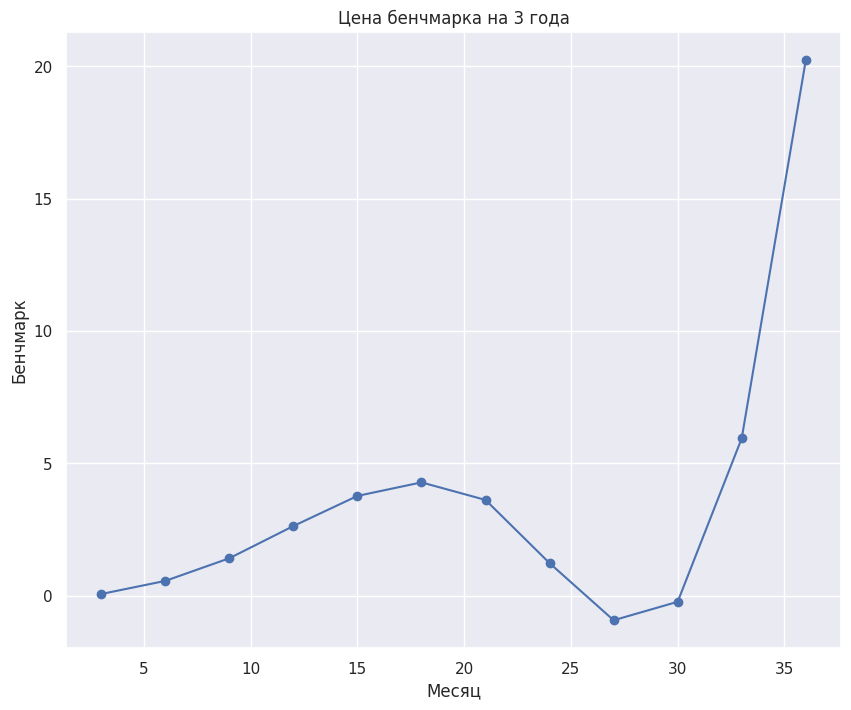

In [27]:
tenors2Y = [3,6,9,12,15,18,21,24]

def F(x, S3, L):
    D3 = 1/(1 + 0.25*L[0])
    D6 = D3/(1 + 0.25*L[1])
    D9 = D6/(1 + 0.25*L[2])
    D12 = D9/(1 + 0.25*L[3])
    D15 = D12/(1 + 0.25*L[4])
    D18 = D15/(1 + 0.25*L[5])
    D21 = D18/(1 + 0.25*L[6])
    D24 = D21/(1 + 0.25*L[7])

    f = scipy.interpolate.interp1d([3,6,9,12,15,18,21,24,36],
                                   np.append(L,x), 'cubic')
    D27 = D24/(1 + 0.25*f(27))
    D30 = D27/(1 + 0.25*f(30))
    D33 = D30/(1 + 0.25*f(33))
    D36 = D33/(1 + 0.25*x)

    return 0.5*S3*(D6 + D12 + D18 + D24 + D30 + D36) - 1 + D36

plt.figure(figsize=(10, 8))
plt.xlabel("Месяц")
plt.ylabel("Бенчмарк")
plt.title("Цена бенчмарка на 3 года")
L36 = scipy.optimize.broyden1(lambda x: F(x,S3,curve2Y), 1.0, f_tol=0.2)
f = scipy.interpolate.interp1d([3,6,9,12,15,18,21,24, 36], np.append(curve2Y, L36), 'cubic')
curve3Y = f(tenors3Y)
plt.scatter(tenors3Y, curve3Y)
plt.plot(tenors3Y, curve3Y);

Теперь посчитаю L60 исходя из цены свопа на 5 лет

$$S_{5Y} = \frac{1 - D_{60M}}{0.5 (D_{6M} + D_{12M} + D_{18M} + D_{24M}+ D_{30M} + D_{36M}+ D_{42M} + D_{48M} + D_{54M} + D_{60M})} $$

In [28]:
tenors3Y = np.array([3,6,9,12,15,18,21,24, 36])

In [29]:
tenors5Y = np.array([3,6,9,12,15,18,21,24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60])

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_nonlin.py:367: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


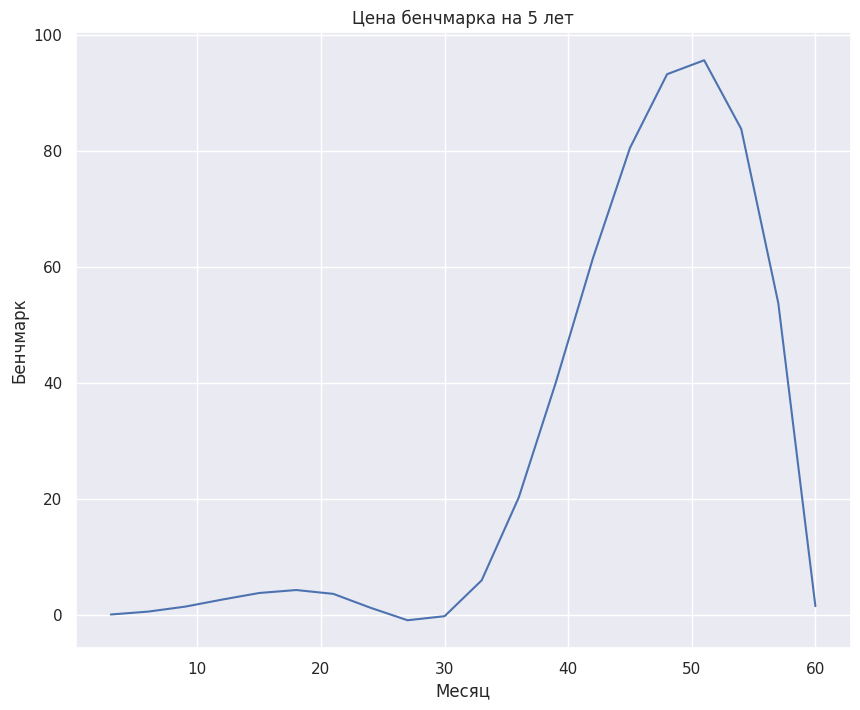

In [32]:
def F(x, S5, L):
    D3 = 1/(1 + 0.25*L[0])
    D6 = D3/(1 + 0.25*L[1])
    D9 = D6/(1 + 0.25*L[2])
    D12 = D9/(1 + 0.25*L[3])
    D15 = D12/(1 + 0.25*L[4])
    D18 = D15/(1 + 0.25*L[5])
    D21 = D18/(1 + 0.25*L[6])
    D24 = D21/(1 + 0.25*L[7])
    D27 = D24/(1 + 0.25*L[8])
    D30 = D27/(1 + 0.25*L[9])
    D33 = D30/(1 + 0.25*L[10])
    D36 = D33/(1 + 0.25*L[11])


    f = scipy.interpolate.interp1d([3,6,9,12,15,18,21,24, 27, 30, 33, 36, 60],
                                   np.append(L,x), 'cubic')
    D39 = D36/(1 + 0.25*f(39))
    D42 = D39/(1 + 0.25*f(42))
    D45 = D42/(1 + 0.25*f(45))
    D48 = D45/(1 + 0.25*f(48))
    D51 = D48/(1 + 0.25*f(51))
    D54 = D51/(1 + 0.25*f(54))
    D57 = D54/(1 + 0.25*f(57))
    D60 = D57/(1 + 0.25*x)

    return 0.5*S5*(D6 + D12 + D18 + D24 + D30 + D36 + D42 + D48 + D54 + D60) - 1 + D60

L60 = scipy.optimize.broyden1(lambda x: F(x,S3,curve3Y), 1.0, f_tol=1)
f = scipy.interpolate.interp1d([3,6,9,12,15,18,21,24, 27, 30, 33, 36, 60], np.append(curve3Y, L60), 'cubic')
curve5Y = f(tenors5Y)

plt.figure(figsize=(10, 8))
plt.xlabel("Месяц")
plt.ylabel("Бенчмарк")
plt.title("Цена бенчмарка на 5 лет")

plt.plot(tenors5Y, curve5Y);